In [1621]:
import numpy as np
from openqaoa.problems import BinPacking, MaximumCut, TSP, ShortestPath
from openqaoa.utilities import plot_graph
import json
import pprint
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
desiredProblemType = 'MaxCut' #options: 'BinPacking', 'MaxCut', 'TSP', 'ShortestPath'

In [1623]:
if desiredProblemType == 'BinPacking': #doesnt seem possible to get a non-trivial example of this problem in less than 12 qubits
    n_items = 2 # number of items
    n_bins = 2 # maximum number of bins the solution will be explored on
    min_weight = 1 # minimum weight of the items
    max_weight = 3 # maximum weight of the items
    weight_capacity = 5 # weight capacity of the bins
    weights = np.random.default_rng(seed=1234).integers(low=min_weight, high=max_weight, size=n_items) # random instance of the problem

    bpp = BinPacking(weights, weight_capacity, n_bins=n_bins, simplifications=False) #it is here that you would specifiy the penalty for the bin packing problem
    quboProb = bpp.qubo

elif desiredProblemType == 'MaxCut':
    G = nx.generators.fast_gnp_random_graph(n=9, p=0.6) #you can fix the seed for the graphs here
    maxcut_prob = MaximumCut(G)
    quboProb = maxcut_prob.qubo

elif desiredProblemType == 'TSP':
    n_cities = 4  # Number of cities for TSP
    connection_probability = 1  # Probability for edge creation in gnp_random_graph
    # Ensure the graph is connected
    G = nx.generators.fast_gnp_random_graph(n=n_cities, p=connection_probability) 

    min_edge_weight = 1
    max_edge_weight = 10 
    rng_weights = np.random.default_rng() # Use a different seed or manage seeds as needed
    for (u, v) in G.edges():
        weight = int(rng_weights.integers(low=min_edge_weight, high=max_edge_weight, endpoint=True)) # endpoint=True includes high value
        G.edges[u, v]['weight'] = weight
    # A is the penalty for not visiting a city or visiting it multiple times.
    # B is the penalty for not having a valid tour structure (e.g. sub-tours or incorrect number of cities at a position)
    B_val = 1
    A_val = 9
    tsp_prob = TSP(G=G, A=A_val, B=B_val) # Using your specified A and B penalties
    quboProb = tsp_prob.qubo
 

elif desiredProblemType == 'ShortestPath': #not sure that the exact solver is working right for this one
    G = nx.generators.fast_gnp_random_graph(n=6, p=0.6)
    nx.set_edge_attributes(G, values = 1, name = 'weight')
    nx.set_node_attributes(G, values = 1, name = 'weight')
    sp_prob = ShortestPath(G, source=0, dest=5)
    quboProb = sp_prob.qubo

quboProb.hamiltonian.expression

/Users/kv18799/Github/QAOAstudygit/openQAOAvenv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


0 + 1.0Z_{0}Z_{6} + 1.0Z_{0}Z_{7} + 1.0Z_{0}Z_{8} + 1.0Z_{1}Z_{2} + 1.0Z_{1}Z_{6} + 1.0Z_{1}Z_{8} + 1.0Z_{2}Z_{3} + 1.0Z_{2}Z_{4} + 1.0Z_{2}Z_{5} + 1.0Z_{2}Z_{6} + 1.0Z_{2}Z_{7} + 1.0Z_{2}Z_{8} + 1.0Z_{3}Z_{7} + 1.0Z_{3}Z_{8} + 1.0Z_{4}Z_{5} + 1.0Z_{4}Z_{7} + 1.0Z_{5}Z_{6} + 1.0Z_{5}Z_{8}

In [1624]:
qubo_dict = quboProb.asdict()
data_to_save = {
    "terms": qubo_dict["terms"],
    "weights": qubo_dict["weights"],
    "constant": qubo_dict.get("constant", 0.0),
    "problem_type": qubo_dict.get("problem_instance", {}).get("problem_type", "unknown")
}

file_path = "qubo_data.json"
with open(file_path, "w") as f:
    json.dump(data_to_save, f)

print(f"QUBO data saved to {file_path}")
print("Saved data structure example:")
#print(json.dumps(data_to_save, indent=2))
print(quboProb.asdict()) # Original full dictionary from OpenQAOA

QUBO data saved to qubo_data.json
Saved data structure example:
{'terms': [[0, 6], [0, 7], [0, 8], [1, 2], [1, 6], [8, 1], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [8, 2], [3, 7], [8, 3], [4, 5], [4, 7], [5, 6], [8, 5]], 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'constant': 0, 'n': 9, 'problem_instance': {'problem_type': 'maximum_cut', 'G': {'directed': False, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 0}, {'id': 1}, {'id': 2}, {'id': 3}, {'id': 4}, {'id': 5}, {'id': 6}, {'id': 7}, {'id': 8}], 'links': [{'source': 0, 'target': 6}, {'source': 0, 'target': 7}, {'source': 0, 'target': 8}, {'source': 1, 'target': 2}, {'source': 1, 'target': 6}, {'source': 1, 'target': 8}, {'source': 2, 'target': 3}, {'source': 2, 'target': 4}, {'source': 2, 'target': 5}, {'source': 2, 'target': 6}, {'source': 2, 'target': 7}, {'source': 2, 'target': 8}, {'source': 3, 'target': 7}, {'source': 3, 'target': 8}, {'source': 4, 'target': 5}, {'s

In [1625]:
#exact solver for later comparison to qunatum results
hamiltonian = quboProb.hamiltonian
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -10.0, Solution: ['111101000', '110111000', '001000111', '000010111']


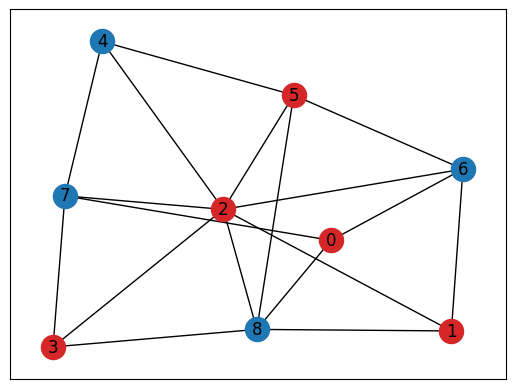

In [1626]:
if desiredProblemType == 'TSP':
    pos = nx.kamada_kawai_layout(G)
    pos = nx.random_layout(G, seed=0)
    pos = nx.spring_layout(G, seed=0)
    fig, ax = plt.subplots(figsize=(10, 7)) # You can adjust figsize as needed
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="grey", width=1.0)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)

    edge_weights = nx.get_edge_attributes(G, 'weight')

    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_weights,
        ax=ax,
        font_color='black', # Color of the weight text
        font_size=8,
        bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=1) # Optional: add a small white background to edge labels for readability
    )
    ax.set_title("Problem Graph")
    plt.axis('off')
    plt.show()
elif desiredProblemType == 'MaxCut':
    pos =  nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
    nx.draw_networkx_nodes(G, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()});

In [1627]:
quboProb.asdict()

{'terms': [[0, 6],
  [0, 7],
  [0, 8],
  [1, 2],
  [1, 6],
  [8, 1],
  [2, 3],
  [2, 4],
  [2, 5],
  [2, 6],
  [2, 7],
  [8, 2],
  [3, 7],
  [8, 3],
  [4, 5],
  [4, 7],
  [5, 6],
  [8, 5]],
 'weights': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'constant': 0,
 'n': 9,
 'problem_instance': {'problem_type': 'maximum_cut',
  'G': {'directed': False,
   'multigraph': False,
   'graph': {},
   'nodes': [{'id': 0},
    {'id': 1},
    {'id': 2},
    {'id': 3},
    {'id': 4},
    {'id': 5},
    {'id': 6},
    {'id': 7},
    {'id': 8}],
   'links': [{'source': 0, 'target': 6},
    {'source': 0, 'target': 7},
    {'source': 0, 'target': 8},
    {'source': 1, 'target': 2},
    {'source': 1, 'target': 6},
    {'source': 1, 'target': 8},
    {'source': 2, 'target': 3},
    {'source': 2, 'target': 4},
    {'source': 2, 'target': 5},
    {'source': 2, 'target': 6},
    {'source': 2, 'target': 7},
    {'source': 2, 'ta